# Modelling Customers Lifetime Value For Non-Contractual Business with Python

https://towardsdatascience.com/whats-a-customer-worth-8daf183f8a4f

In [1]:
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

### The Data

http://archive.ics.uci.edu/ml/datasets/online+retail

In [2]:
df = pd.read_excel("Online_Retail.xlsx")
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


As usual, we have some cleaning to do, then create a new dataframe that only contains CustomerID, InvoiceDate (remove the time) and add a new column — sales:

In [3]:
import datetime as dt


df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date
df = df[pd.notnull(df['CustomerID'])]
df = df[(df['Quantity'] > 0)]
df['Sales'] = df['Quantity'] * df['UnitPrice']

cols_of_interest = ['CustomerID', 'InvoiceDate', 'Sales']
df = df[cols_of_interest]

print(df.head())
print('\n', df['CustomerID'].nunique())

   CustomerID InvoiceDate  Sales
0     17850.0  2010-12-01  15.30
1     17850.0  2010-12-01  20.34
2     17850.0  2010-12-01  22.00
3     17850.0  2010-12-01  20.34
4     17850.0  2010-12-01  20.34

 4339


### CLV Model Definition

For the CLV models, the following nomenclature is used:

- Frequency represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases.
- T represents the age of the customer in whatever time units chosen (daily, in our dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.
- Recency represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

The following analysis is conducted in Python using Lifetimes packagedeveloped by Cameron Davidson-Pilon, data scientist at Shopify, and the code was largely borrowed from Lifetimes documentation.

### Data Explore

In [4]:
from lifetimes.plotting import *
from lifetimes.utils import *
# from lifetimes.estimation import *


data = summary_data_from_transaction_data(df, 'CustomerID', 'InvoiceDate', 
                                          monetary_value_col='Sales', observation_period_end='2011-12-9')
data.head(2)

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667


There are 4339 customers under our analysis.

CustomerID 12346 made 1 purchase only (no repeat), so his frequency and recency are 0, and his age is 325 days (e.g. the duration between his first purchase and the end of the period in the analysis).

count    4339.000000
mean        2.864024
std         5.952745
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       131.000000
Name: frequency, dtype: float64

 0.3569946992394561


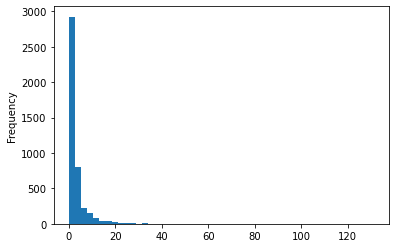

In [5]:
data['frequency'].plot(kind='hist', bins=50)
print(data['frequency'].describe())
print('\n', sum(data['frequency'] == 0) / float(len(data)))

Among all customers in our data, more than 35% of them only made purchase once (no repeat).

In [33]:
from lifetimes import BetaGeoFitter


bgf = BetaGeoFitter(penalizer_coef=0.1)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 49.41, b: 0.00, r: 0.59>


### Visualizing our frequency/recency matrix

Consider: a customer has made purchase every day for four weeks straight, and then we haven’t heard from him in months. What are the chances he is still “alive”? Pretty small, right? On the other hand, a customer who historically made purchase once a quarter, and again last quarter, is likely still alive. We can visualize this relationship using the frequency/recency matrix, which computes the expected number of transactions an artificial customer is to make in the next time period, given his recency (age at last purchase) and frequency (the number of repeat transactions he has made).

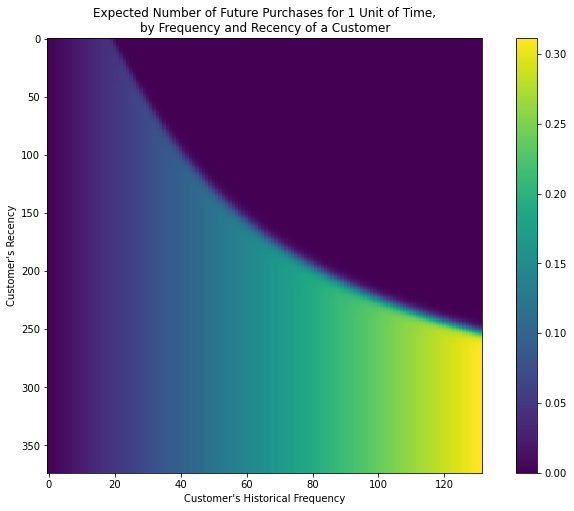

In [34]:
from lifetimes.plotting import plot_frequency_recency_matrix
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(12, 8))

plot_frequency_recency_matrix(bgf)

plt.show()

If a customer has made 120 purchases, and his latest purchase was when he was approximately 350 days old (i.e. Recency: the duration between her first transaction and her latest transaction is 350 days), then he is our best customer (bottom-right).

Customers who have purchased a lot and purchased recently will likely be the best customers in the future. We will never have enough of them.

Customers who have purchased a lot but not recently (top-right corner), have probably gone.

There are also another type of customers that around (40, 300) that represents the customer who buys infrequently, and we have not seen him recently, so he might buy again. However, we are not sure if he has gone or just between purchases.

We can predict which customers are surely alive:

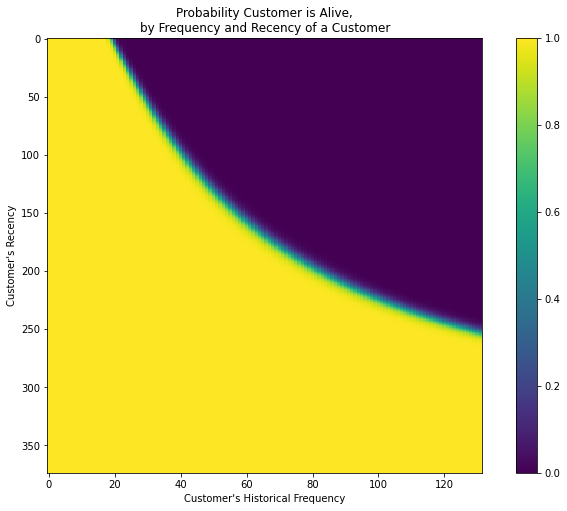

In [35]:
from lifetimes.plotting import plot_probability_alive_matrix


fig = plt.figure(figsize=(12, 8))

plot_probability_alive_matrix(bgf)

plt.show()

Customers who have purchased recently are almost surely “alive”.

Customers who have purchased a lot but not recently, are likely to have dropped out. And the more they bought in the past, the more likely they have dropped out. They are represented in the upper-right.

We are ranking customers from “highest expected purchases in the next period” to lowest. Models expose a method that will predict a customer’s expected purchases in the next period using their history.

In [36]:
t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], 
                                                                                      data['recency'], data['T'])
# data.sort_values(by='predicted_purchases').tail(5)
data.sort_values(by='predicted_purchases', ascending=False).head(5)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
14911.0,131.0,372.0,373.0,1093.661679,0.311527
12748.0,113.0,373.0,373.0,298.360885,0.268915
17841.0,111.0,372.0,373.0,364.452162,0.264180
15311.0,89.0,373.0,373.0,677.729438,0.212099
14606.0,88.0,372.0,373.0,135.890114,0.209731


Listed above are our top 5 customers that the model expects them to make purchases in the next day. The predicted_purchases column represents their expected number of purchases while the other three columns represent their current RF metrics. The BG/NBD model believes these individuals will be making more purchases within the near future as they are our current best customers.

### Assessing model fit

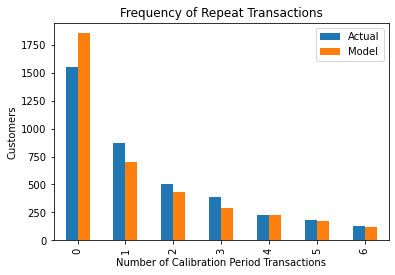

In [37]:
from lifetimes.plotting import plot_period_transactions


plot_period_transactions(bgf)

plt.show()

Not bad, out model does not suck. So, we can continue on with our analysis.

We now partition the dataset into a calibration period dataset and a holdout dataset. This is important as we want to test how our model performs on data not yet seen (just like cross-validation in machine learning practice).

In [38]:
from lifetimes.utils import calibration_and_holdout_data


summary_cal_holdout = calibration_and_holdout_data(df, 'CustomerID', 'InvoiceDate',
                                        calibration_period_end='2011-06-08',
                                        observation_period_end='2011-12-9' )   
summary_cal_holdout.head(2)

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346.0,0.0,0.0,141.0,0.0,184.0
12347.0,2.0,121.0,183.0,4.0,184.0


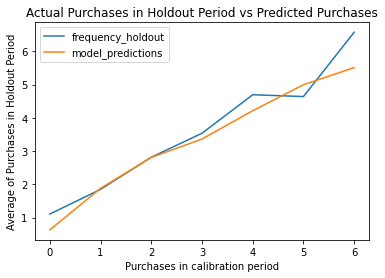

In [39]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases


bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

plt.show()

In this plot, we separate the data into both a in-sample (calibration) and validation (holdout) period. The sample period consists the beginning to 2011–06–08; the validation period spans from 2011–06–09 to 2011–12–09. The plot groups all customers in the calibration period by their number of repeat purchases (x-axis) and then averages over their repeat purchases in the holdout period (y-axis). The green and blue line presents the model prediction and actual result of the y-axis respectively. As we can see, our model is able to very accurately predict the customer base’s behaviour out of the sample, the model under-estimates at 4 purchases and after 5 purchases.

### Customer transactions predictions

In [40]:
t = 10
individual = data.loc[12347]
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.15929394518540368

Our model predicts that customer 12347’s future transaction is 0.157 in 10 days.

### Customer probability histories

Given a customer transaction history, we can calculate their historical probability of being alive, according to our trained model. For example, we want to look at our best customer’s transactions history and see the probability of being alive:

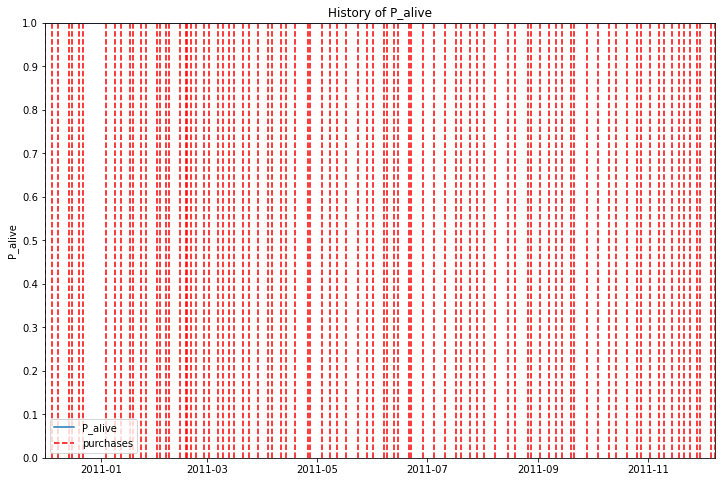

In [44]:
# something doesn't work right

from lifetimes.plotting import plot_history_alive
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(12, 8))
id = 14606
days_since_birth = 365
sp_trans = df.loc[df['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')

plt.show()

Our best customer is definitely alive, however, he had several hiatus in the second half of the year 2011.

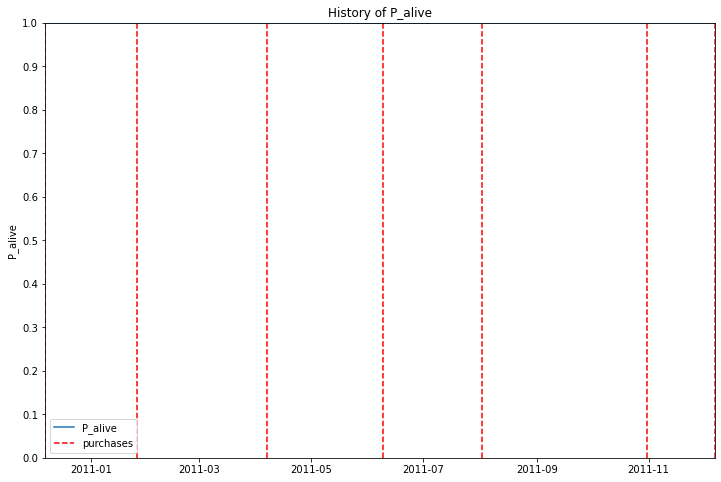

In [45]:
# something doesn't work right

fig = plt.figure(figsize=(12, 8))
id = 12347
days_since_birth = 365
sp_trans = df.loc[df['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')

plt.show()

On the other hand, this customer had only purchased once and has dropped off for a long time with a 100% chance that he is dead.

### Estimating customer lifetime value using gamma-gamma model of monetary value

We are now taking into account the economic value of each transaction. To estimate this we use the Gamma-Gamma submodel presented by Dr. Peter Fader and Dr. Bruce Hardie from Wharton, to predict likely spend per transaction in the future at the customer level.

We are only estimating the customers who had at least one repeat purchase with us. Therefore, we are estimating for 2,790 customers.

In [46]:
returning_customers_summary = data[data['frequency'] > 0]
returning_customers_summary.head(2)
# print(returning_customers_summary.head(2))

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
12347.0,6.0,365.0,367.0,599.701667,0.015834
12348.0,3.0,283.0,358.0,301.480000,0.008820


In [47]:
print(len(returning_customers_summary))

2790


In [50]:
from lifetimes import GammaGammaFitter


ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.57>


After applying Gamma-Gamma model, now we can estimate average transaction value for each customer. Phew!

In [52]:
ggf.conditional_expected_average_profit(data['frequency'], data['monetary_value']).head(10)

CustomerID
12346.0    416.917667
12347.0    569.988807
12348.0    333.762672
12349.0    416.917667
12350.0    416.917667
12352.0    376.166864
12353.0    416.917667
12354.0    416.917667
12355.0    416.917667
12356.0    324.008941
dtype: float64